# Importing necessary utilities

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
from temp_setpoint import Tref, time_list, n_tf
from reactor_model import max_temp, min_temp, max_conc, min_conc, num_temp, num_conc, temp_list, conc_list, tj_list, state_index, new_state, T, Ca
import time
import tensorflow as tf

# Replay memory class

In [15]:
class ReplayMemory:
    def __init__(self, max_size, num_cols):
        self.memory = np.zeros((max_size, num_cols))
        self.size = 0
        self.set_size = max_size
        self.curr_index = 0
        self.is_full = False
    def push(self, item):
        if self.size >= self.set_size and self.is_full == False:
            self.is_full = True
            self.curr_index = 0
        elif self.curr_index >= self.set_size and self.is_full == True:
            self.curr_index = 0
        elif self.size < self.set_size:
            self.size += 1
        self.memory[self.curr_index] = item
        self.curr_index += 1
    def get(self, index=None):
        if index is None: return np.copy(self.memory[0: self.size])
        return np.copy(self.memory[index])
    def get_batch(self, size):
        end_index = self.set_size if self.is_full else self.curr_index
        indexes = np.random.choice(range(0, end_index), size=size, replace=False)
        return np.copy(self.memory[indexes])


# Defining hyperparameters

In [16]:
# discount factor for q learning
gamma = 1
learning_rate = 1e-2
e = 0.05

# Defining model function

In [17]:
def make_model():
    """ Make model for continous state space and discrete action space using keras API
    """
    Q_func_model = tf.keras.models.Sequential()
    Q_func_model.add(tf.keras.layers.Dense(70, input_shape=(3, ), activation="relu"))
    Q_func_model.add(tf.keras.layers.Dense(70, activation="relu"))
    Q_func_model.add(tf.keras.layers.Dense(70, activation="relu"))
    Q_func_model.add(tf.keras.layers.Dense(70, activation="relu"))
    Q_func_model.add(tf.keras.layers.Dense(70, activation="relu"))
    Q_func_model.add(tf.keras.layers.Dense(70, activation="relu"))
    Q_func_model.add(tf.keras.layers.Dense(num_temp, activation="linear"))
    Q_func_model.compile(
        loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["mse"]
    )
    Q_func_model.build()
    return Q_func_model

# Defining policy

In [18]:
def greedy_policy(model, state, time_index):
    """ Calculates action based on Q matrix.
    Parameters:
        model: the neural network that takes state as input and gives Q values for different actions as outputs
        state: a 2 x 1 numpy array
        time_index: discrete time index in time_list"""
    q_action_array = model.predict(np.array([[time_index, state[T, 0], state[Ca, 0]]]), verbose=0)[0]
    tj_index = np.argmax(q_action_array)
    tj_indexes = np.where(q_action_array == q_action_array[tj_index])[0]
    tj_index = np.random.choice(tj_indexes)
    return tj_index

def policy(model, state, time_index, e):
    """ Calculates action based on Q matrix.
    Parameters:
        state: a 2 x 1 numpy array
        time_index: discrete time index in time_list
        e: epsilon - probability of choosing a random action"""
    rand_number = np.random.uniform()
    if rand_number < e: return np.random.randint(num_temp)
    else: return greedy_policy(model, state, time_index)

# Defining reward functions

In [19]:
def calc_reward(state, action, prev_action, iter_num):
    """ Calculate reward of the action done on state for the current iteration
    Parameters:
        state: a 2 x 1 numpy array
        action: a scalar value
        prev_action: a scalar value
        iter_num: integer"""
    Q = np.array([[1, 0],[0, 1]])
    R = 0.1
    if state is None: return -1*np.inf
    elif not (min_conc <= float(state[Ca]) <= max_conc): return -1*np.inf
    d_action = action - prev_action
    x = state - np.array([Tref[iter_num], 0]).reshape(-1, 1)
    # cost_val = x.T @ (Q @ x)
    cost_val = x.T @ (Q @ x) + R * (d_action**2)
    return -1*np.float64(cost_val)

# Optimum q value out of model for given state/states

In [20]:
def opt_q_val(model, state):
    """ Calculates action based on Q matrix.
    Parameters:
        model: the neural network that takes state as input and gives Q values for different actions as outputs
        state: a 2 x 1 numpy array
        time_index: discrete time index in time_list"""
    q_action_array = model(state)[0]
    return np.max(q_action_array)

def opt_q_val_many_states(model, states):
    """ Calculates action based on Q matrix.
    Parameters:
        model: the neural network that takes state as input and gives Q values for different actions as outputs
        states: a n x 3 numpy array"""

    q_action_arrays = model(states)
    opt_q_values = np.max(q_action_arrays, axis=1)
    # some new line of code
    terminal_states_indexes = np.where(states[:, 0] == n_tf)[0]
    # print(f"{states=}")
    # print(f"{terminal_states_indexes=}")
    opt_q_values[terminal_states_indexes] = 0
    # print(f"{opt_q_values=}")
    # end
    return opt_q_values

def argmax_q_val_many_states(model, states):
    """ Calculates action based on Q matrix.
    Parameters:
        model: the neural network that takes state as input and gives Q values for different actions as outputs
        states: a n x 3 numpy array"""

    q_action_arrays = model(states)
    opt_q_values = np.argmax(q_action_arrays, axis=1)
    return opt_q_values

# Training code

In [21]:
def train_rl_model(num_episodes):
    time_, T_, C_, Tj, time_next, T_next, C_next, R = list(range(0, 8))
    set_steps = 5
    # initialize replay memory
    replay_memory = ReplayMemory(max_size = 600, num_cols = 8)
    # initialise action value function
    Q = make_model()
    # initialise target action value function to generate labels
    Q_t = make_model()
    Q_t.set_weights(Q.get_weights())
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_func = tf.keras.losses.mse
    batch_size = 300
    for episode_index in range(num_episodes):
        # initialize markov chain with initial state
        state = np.array(
            [np.random.uniform(min_temp, max_temp), np.random.uniform(min_conc, max_conc)],
        ).reshape(-1, 1)
        prev_action = None
        for t in range(0, n_tf):
            # epsilon greedy action selection
            action_index = policy(Q, state, t, e)
            action = tj_list[action_index]
            print(action_index)
            # executing action, observing reward and next state to store experience in tuple
            next_state = new_state(state, action)
            if t == 0: reward = calc_reward(state, action, action, t)
            else: reward = calc_reward(state, action, prev_action, t)
            prev_action = action
            # store experience in replay memory
            replay_memory.push(np.array([t, state[T,0], state[Ca,0], action_index, t+1, next_state[T,0], next_state[Ca,0], reward]))
            # get replay memory
            if replay_memory.size < batch_size:
                state = next_state
                continue

            rand_batch = replay_memory.get_batch(size=batch_size)
            # get inputs and labels for neural network
            inputs = rand_batch[:, time_:C_+1]
            next_inputs = rand_batch[:, time_next:R]
            action_args  = rand_batch[:, Tj]
            labels = rand_batch[:, R] + gamma * opt_q_val_many_states(Q_t, next_inputs)
            # training model
            masks = tf.one_hot(np.rint(action_args).astype(int), num_temp)
            with tf.GradientTape() as tape:
                Q_values = Q(inputs)
                Q_action = tf.reduce_sum(tf.multiply(Q_values, masks), axis=1)
                loss = loss_func(labels, Q_action)
            gradients = tape.gradient(loss, Q.trainable_variables)
            optimizer.apply_gradients(zip(gradients, Q.trainable_variables))
            # update state
            state = next_state
        if episode_index % set_steps == 0:
            Q_t.set_weights(Q.get_weights())
    return Q

# Running reactor to check performance

3
3


<ipython-input-19-418919fd4b4b>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  elif not (min_conc <= float(state[Ca]) <= max_conc): return -1*np.inf
<ipython-input-19-418919fd4b4b>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -1*np.float64(cost_val)


3
3
3
3
3
3
3
3
7
3
8
3
3
3
3
3
9
4
9
9
9
9
9
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
2
1
9
9
9
9
9
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
9
9
9
9
9
9
9
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
0
9
9
9
9
9
9
9
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
9
9
9
9
9
9
9
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
9
9
9
9
9
3
9
3
3
3
3
3
3
3
3
3
3
3
0
3
3
3
3
3
3
9
9
9
9
9
9
9
9
3
3
0
3
3
3
3
3
8
3
3
3
3
3
3
3
3
9
9
8
9
9
9
9
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
9
9
9
9
9
9
9
3
3
5
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
9
9
9
9
9
9
8
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
9
9
9
9
9
9
9
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
3
3
9
9
9
6
9
8
9
0
0
0
0
0
0
0
0
0
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
9
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
2
5
5
5
5
5
5
5
5
5
5
4
4
4
4
1
5
5
5
5
5
7
5
5
5
5
5
5
5
5
5
5
5
5
5
5
9
5
5
4
4
5
5
5
5
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
9
4
5
5
5
5
4
4
4
4
3
4
5
6
5
5
6
6
6
6
6
6
5
8
5
9
9
9
9
4
4
4
5
5
5
5
5
5
6
8
8
8
6
5
5
5
6
6
6
6
7
7


<ipython-input-22-14fe21c1c55d>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state_arr[i] = float(curr_state[T])


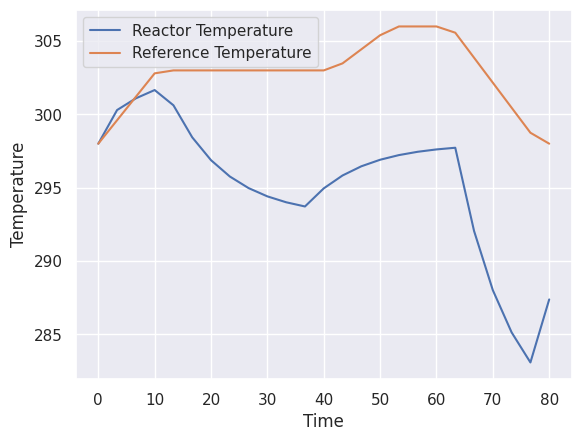

In [22]:
if __name__ == "__main__":
    start_time = time.perf_counter()
    model = train_rl_model(30)
    cpu_time = time.perf_counter() - start_time
    curr_state = np.array([298, 0.6]).reshape(-1, 1)
    state_arr = np.zeros_like(time_list)
    action_arr = np.zeros_like(time_list)
    reward_arr = np.zeros_like(time_list)
    for i in range(n_tf):
        state_arr[i] = float(curr_state[T])
        tj_index = greedy_policy(model, curr_state, i)
        action_arr[i] = tj_list[tj_index]
        #reward_computation
        if i == 0: j = i
        else: j = i - 1
        reward_arr[i] = calc_reward(curr_state, action_arr[i], action_arr[j], i)
        # reward_computation end
        curr_state = new_state(curr_state, tj_list[tj_index])
    df = pd.DataFrame({"Temperature": state_arr, "Time": time_list, "Reference": Tref, "Jacket Temperature": action_arr, "Reward": reward_arr})
    sns.set_theme()
    sns.lineplot(
        data=df,
        x="Time",
        y="Temperature",
        label="Reactor Temperature",
    )
    sns.lineplot(
        data=df,
        x="Time",
        y="Reference",
        legend="full",
        label="Reference Temperature",
    )
    # sns.lineplot(x=time_list, y=action_arr, drawstyle='steps-pre', label="Jacket Temperature")

    MAE = np.sum(np.abs(state_arr-Tref))/len(state_arr)
    RMSE = (np.sum((state_arr-Tref)**2)/len(state_arr))**0.5

In [23]:
days = int(cpu_time // 86400)
hrs = int((cpu_time -  86400 * days)// 3600)
mins = int((cpu_time - 3600 * hrs - 86400 * days) // 60)
seconds = int((cpu_time - 60 * mins - 3600 * hrs - 86400 * days) // 1)
print(f"{days = }\n{hrs = }\n{mins = }\n{seconds = }")

days = 0
hrs = 0
mins = 1
seconds = 25


In [24]:
model.predict([[1, 298, 0.6]])

1/1 [==============================] - 0s 38ms/step


array([[-350.1435  , -147.60277 , -254.29308 , -134.47818 , -140.97423 ,
        -113.82275 ,  -97.38422 , -152.00844 , -132.44872 , -113.641815]],
      dtype=float32)

In [25]:
(MAE, RMSE)

(7.6219874848026965, 8.716996292897072)

In [26]:
model.predict([[9, 298, 0.6]])

1/1 [==============================] - 0s 50ms/step


array([[-1016.5838  ,  -409.7664  ,  -387.10693 ,  -283.3099  ,
         -121.555756,  -131.44969 ,  -489.37503 ,  -134.99515 ,
         -354.3809  ,  -205.87692 ]], dtype=float32)